In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
expression = pd.read_csv("TCGA.STAD.expression.txt", sep="\t")
expression.set_index(["patient_id"], inplace=True)
expression = expression.drop("sample_id", axis=1)
expression = expression.fillna(0)
metadata = pd.read_csv("TCGA.STAD.metadata.txt", sep="\t")
metadata.set_index("patient_id", inplace=True)
mutations = pd.read_csv("TCGA.STAD.mutations.txt", sep="\t")

# Unnormalized

In [3]:
expression = expression.fillna(0)
expression_scaled = expression

# PCA
pca = PCA(n_components=20) 
pca_result = pca.fit_transform(expression_scaled)
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance}")

# MDS
mds = MDS(n_components=20, random_state=42)
mds_result = mds.fit_transform(expression_scaled)

# t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(expression_scaled)

# UMAP
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_result = umap_model.fit_transform(expression_scaled)

PCA Explained Variance: [0.291529   0.21915181 0.09318604 0.05926469 0.0365876  0.03084665
 0.02109178 0.01975196 0.01566814 0.01481585 0.01334135 0.01128743
 0.01051186 0.01001313 0.00944657 0.00934993 0.00843897 0.00691838
 0.00572544 0.00522036]


/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tscc/nfs/home/s5xu/mambaforge/envs/singlecell/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


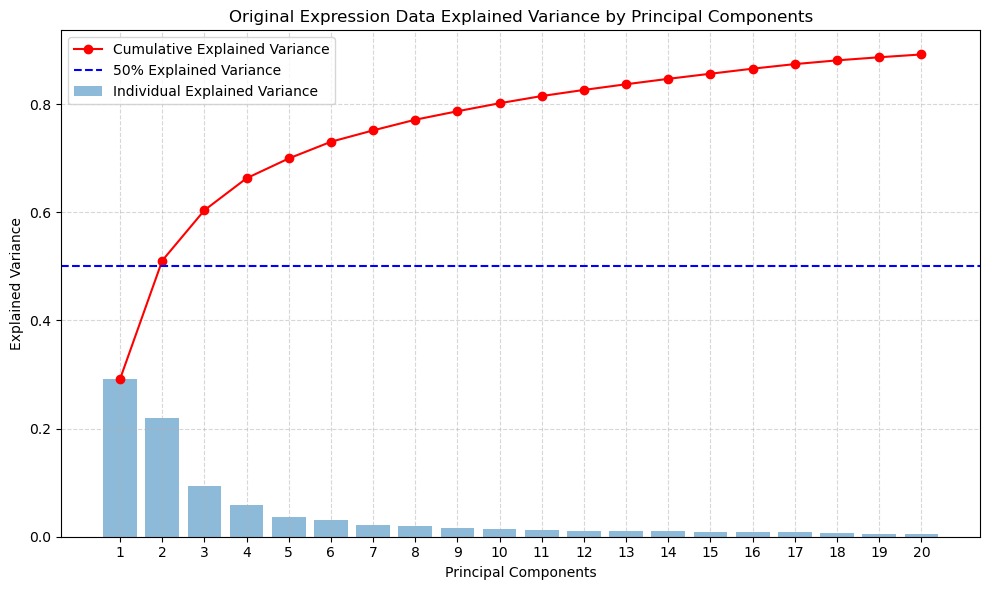

In [4]:
cumulative_variance = np.cumsum(explained_variance)

threshold = 0.5

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='red', label='Cumulative Explained Variance')
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Original Expression Data Explained Variance by Principal Components')
plt.xticks(np.arange(1, len(explained_variance)+1, step=1))
plt.axhline(y=threshold, color='blue', linestyle='--', linewidth=1.5, label='50% Explained Variance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [5]:
results = pd.DataFrame({
    "PCA_1": pca_result[:, 0], "PCA_2": pca_result[:, 1],
    "MDS_1": mds_result[:, 0], "MDS_2": mds_result[:, 1],
    "TSNE_1": tsne_result[:, 0], "TSNE_2": tsne_result[:, 1],
    "UMAP_1": umap_result[:, 0], "UMAP_2": umap_result[:, 1],
}, index=expression.index)
results = results.join(metadata, how="inner")

# Kmean
for dimension in [("pca", pca_result), ('mds', mds_result),('tsne', tsne_result),('umap', umap_result)]:
    input_result = dimension[1]
    name = dimension[0]
    for i in range(2, 8):
        cluster = i
        kmeans = KMeans(n_clusters=cluster, random_state=42)
        cluster_labels = kmeans.fit_predict(input_result)
        results[f"{name.upper()}_{i}_cluster"] = cluster_labels
        sil_score = silhouette_score(input_result, cluster_labels)
        print(f"Silhouette Score for K-means {name} (k={cluster}): {sil_score:.3f}")

Silhouette Score for K-means pca (k=2): 0.755
Silhouette Score for K-means pca (k=3): 0.711
Silhouette Score for K-means pca (k=4): 0.485
Silhouette Score for K-means pca (k=5): 0.498
Silhouette Score for K-means pca (k=6): 0.173
Silhouette Score for K-means pca (k=7): 0.231
Silhouette Score for K-means mds (k=2): 0.719
Silhouette Score for K-means mds (k=3): 0.663
Silhouette Score for K-means mds (k=4): 0.403
Silhouette Score for K-means mds (k=5): 0.346
Silhouette Score for K-means mds (k=6): 0.137
Silhouette Score for K-means mds (k=7): 0.153
Silhouette Score for K-means tsne (k=2): 0.272
Silhouette Score for K-means tsne (k=3): 0.294
Silhouette Score for K-means tsne (k=4): 0.267
Silhouette Score for K-means tsne (k=5): 0.269
Silhouette Score for K-means tsne (k=6): 0.262
Silhouette Score for K-means tsne (k=7): 0.276
Silhouette Score for K-means umap (k=2): 0.229
Silhouette Score for K-means umap (k=3): 0.410
Silhouette Score for K-means umap (k=4): 0.400
Silhouette Score for K-me

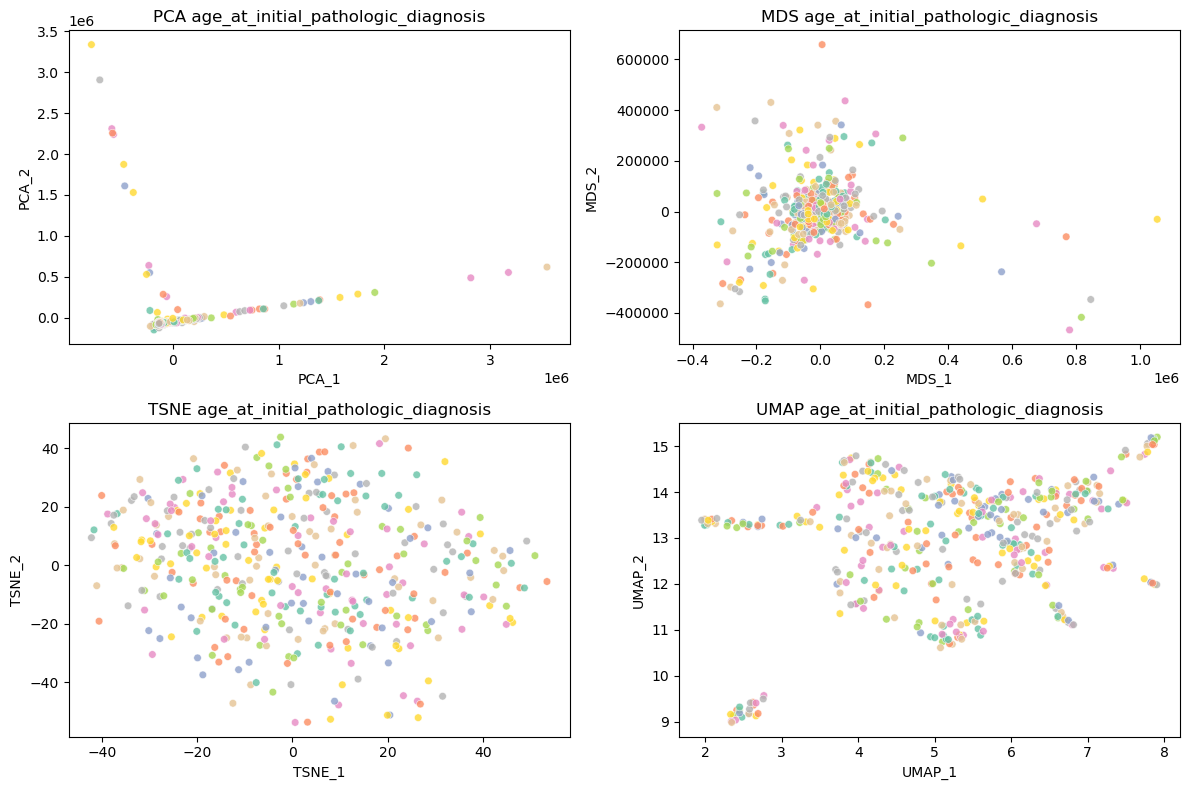

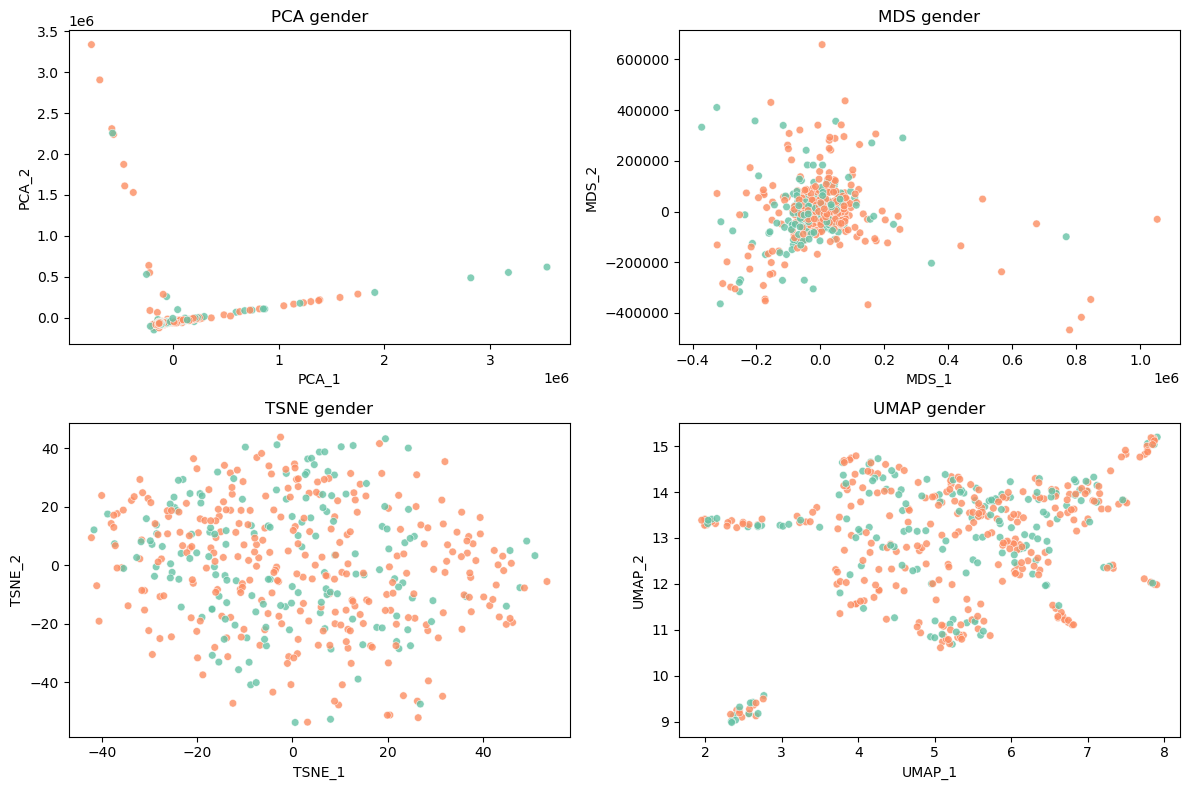

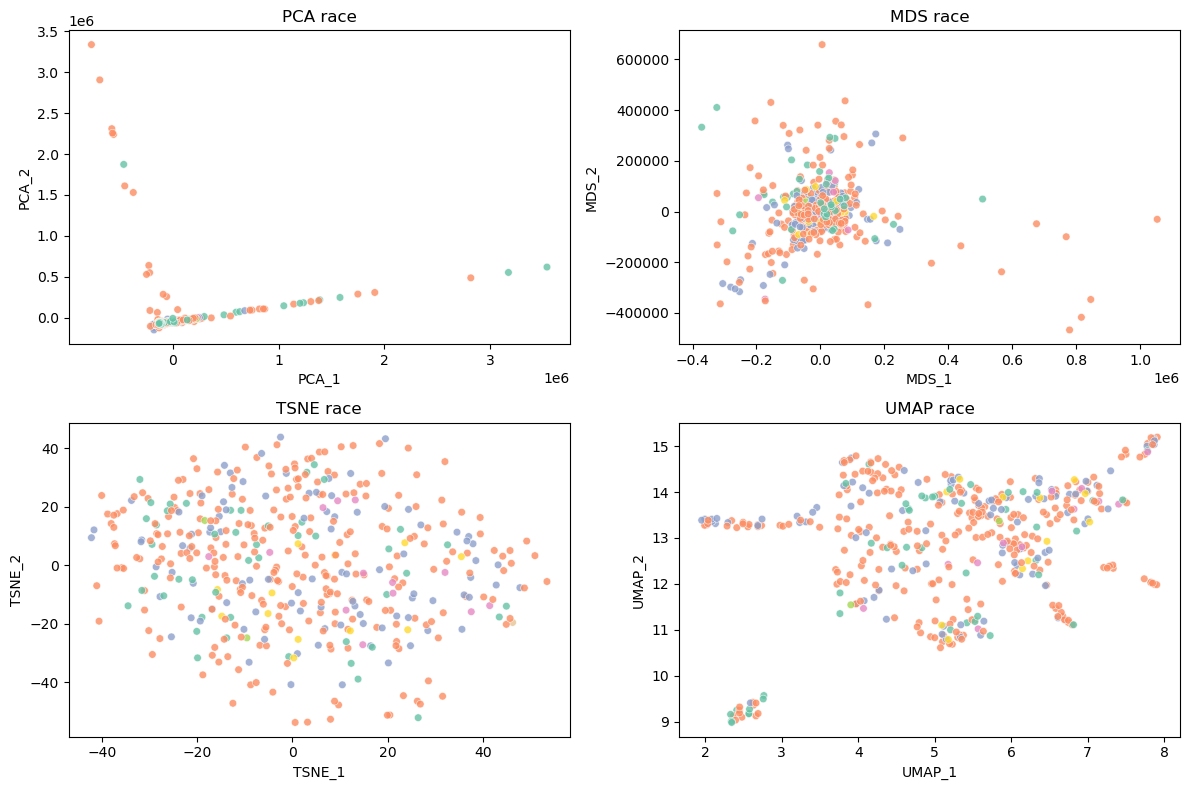

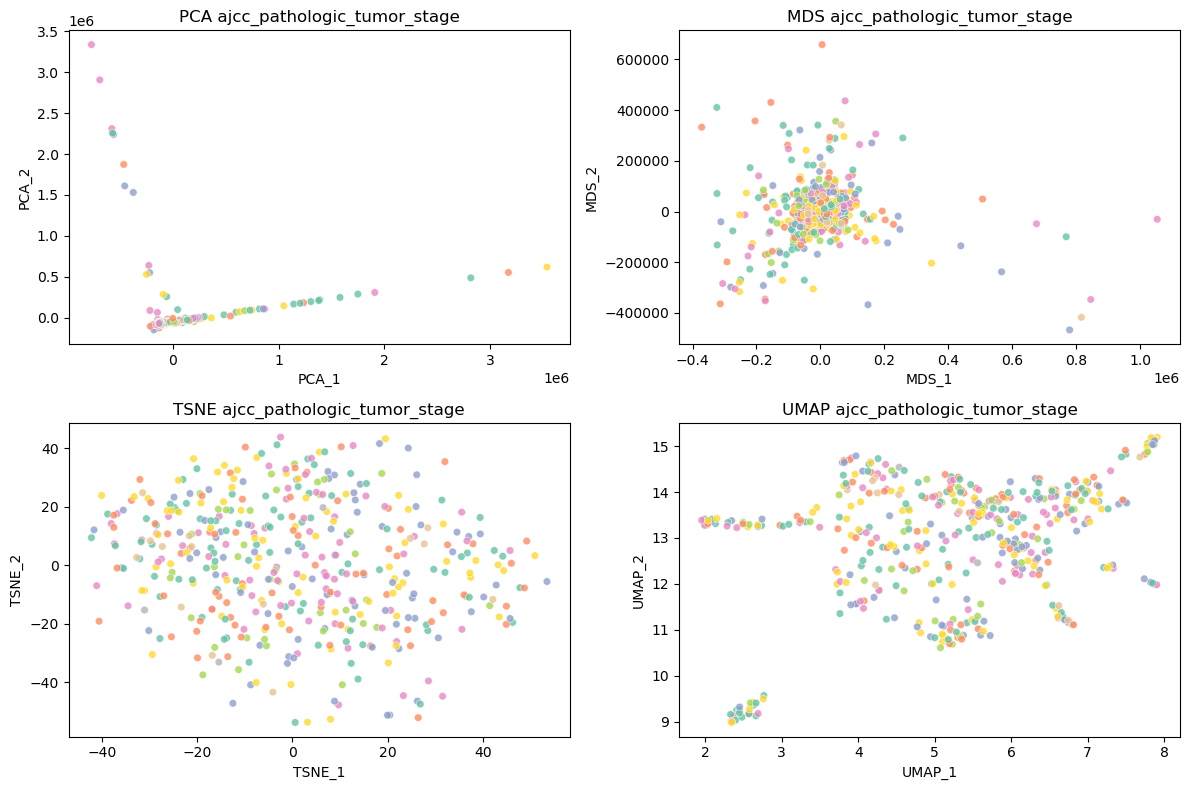

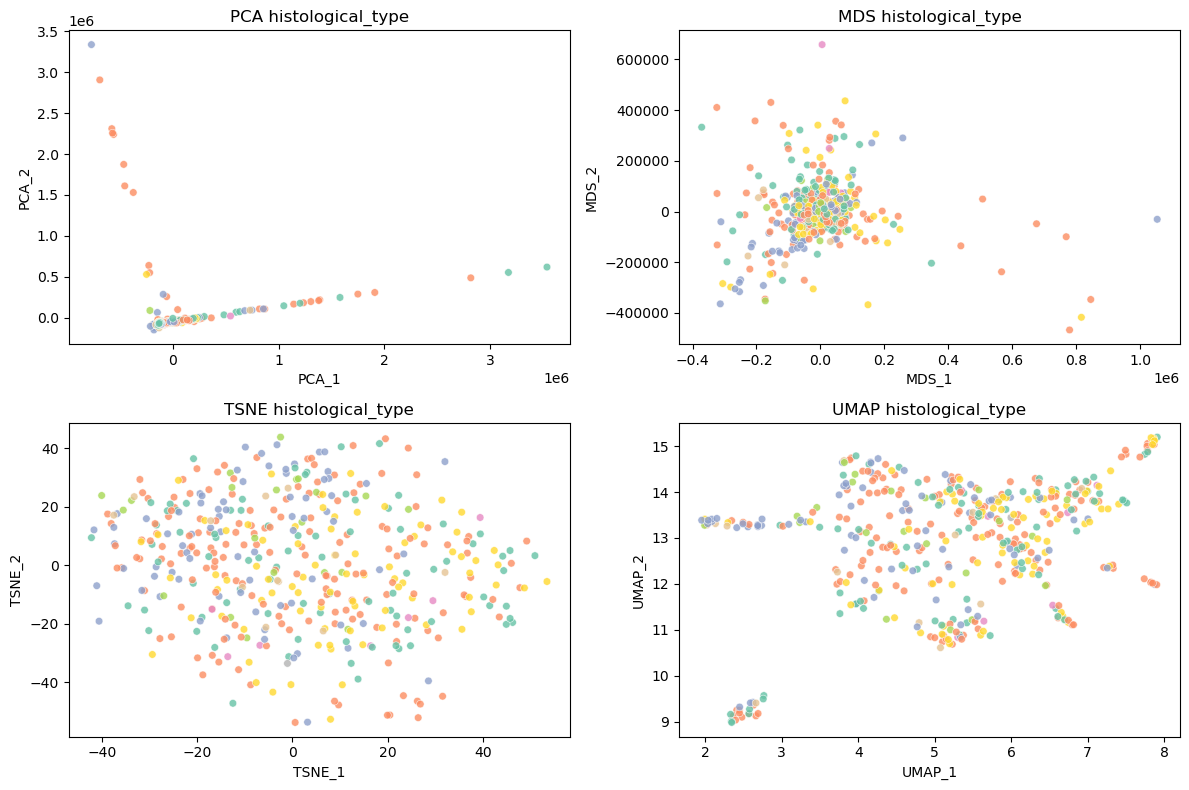

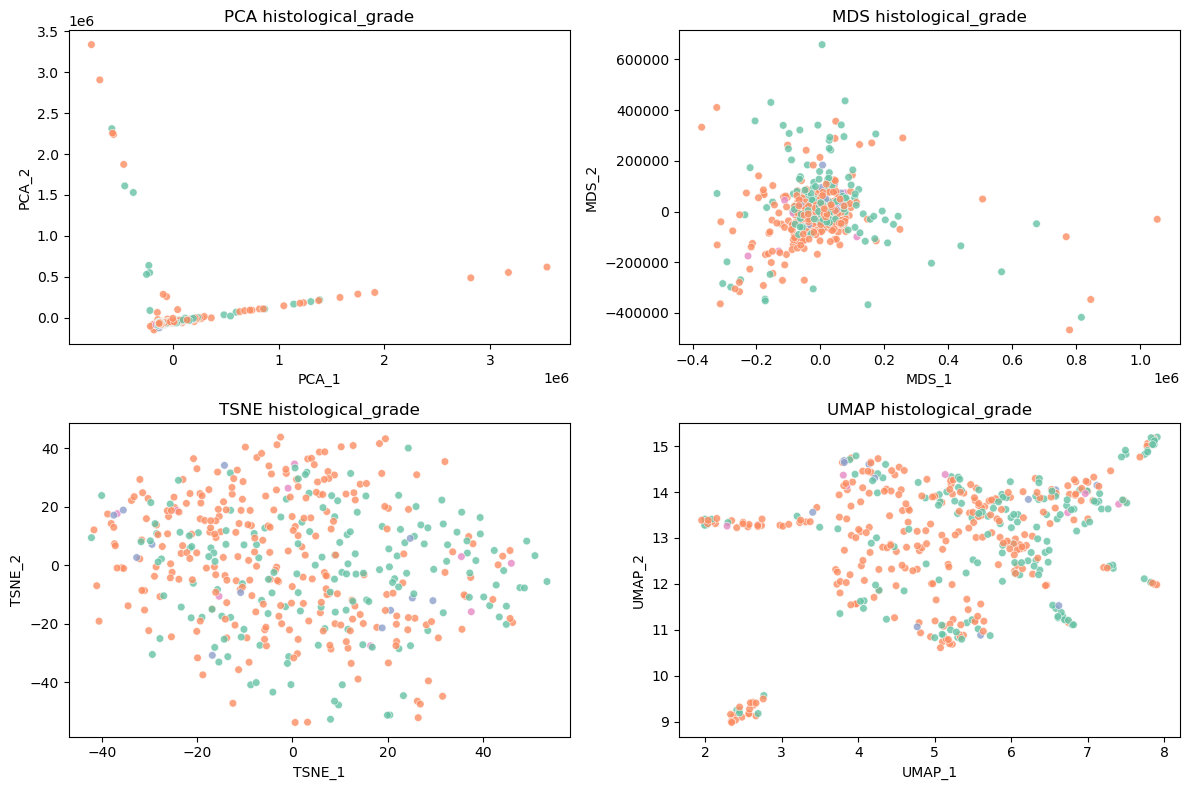

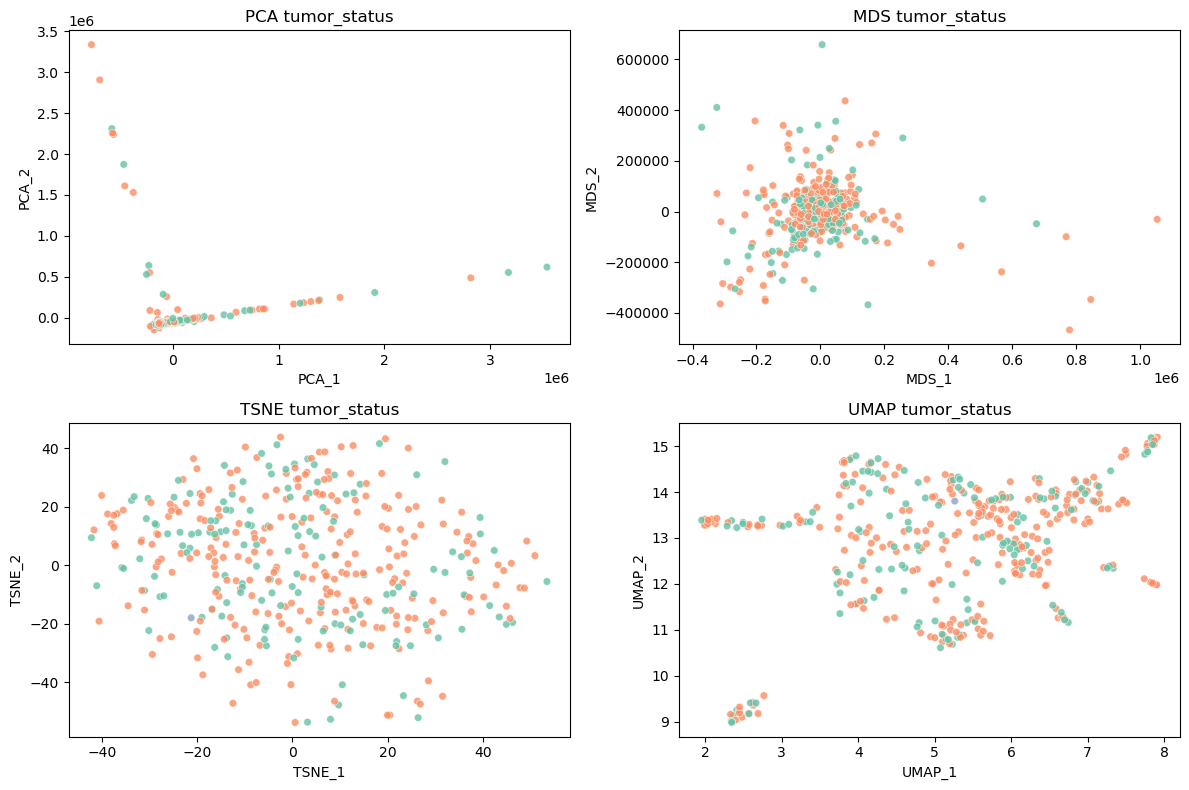

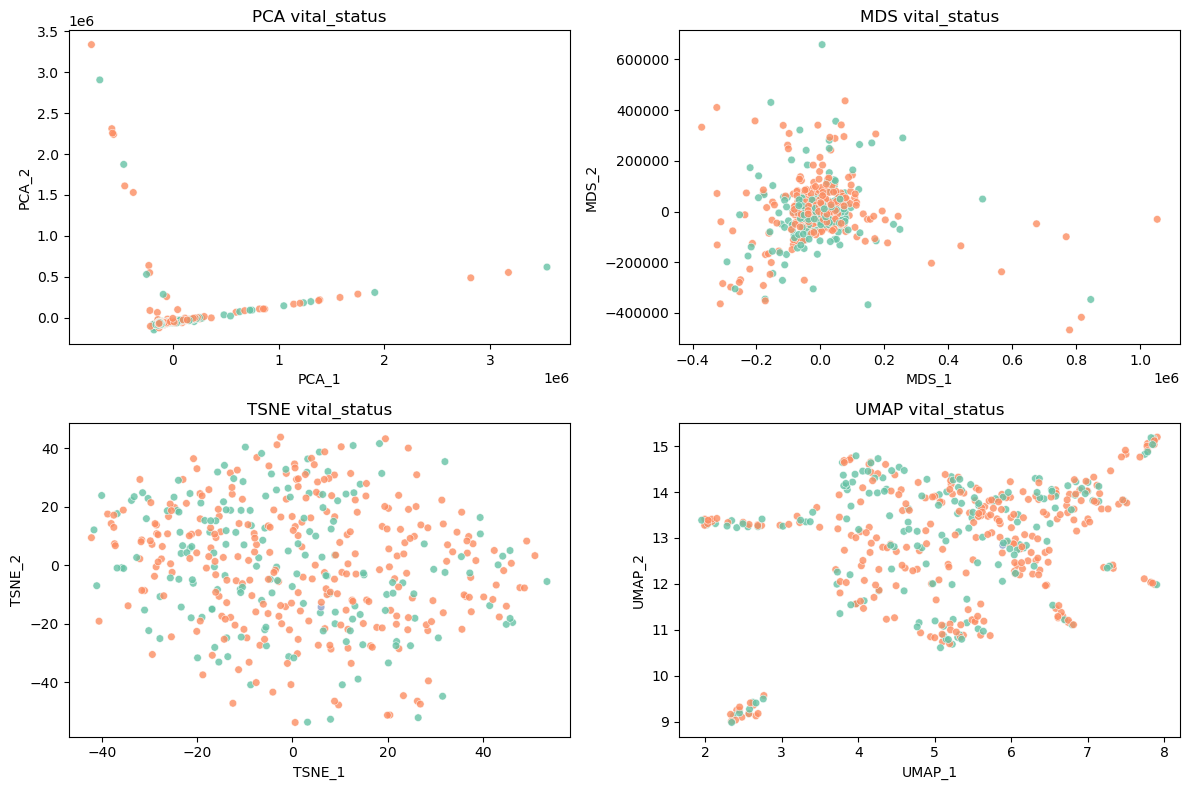

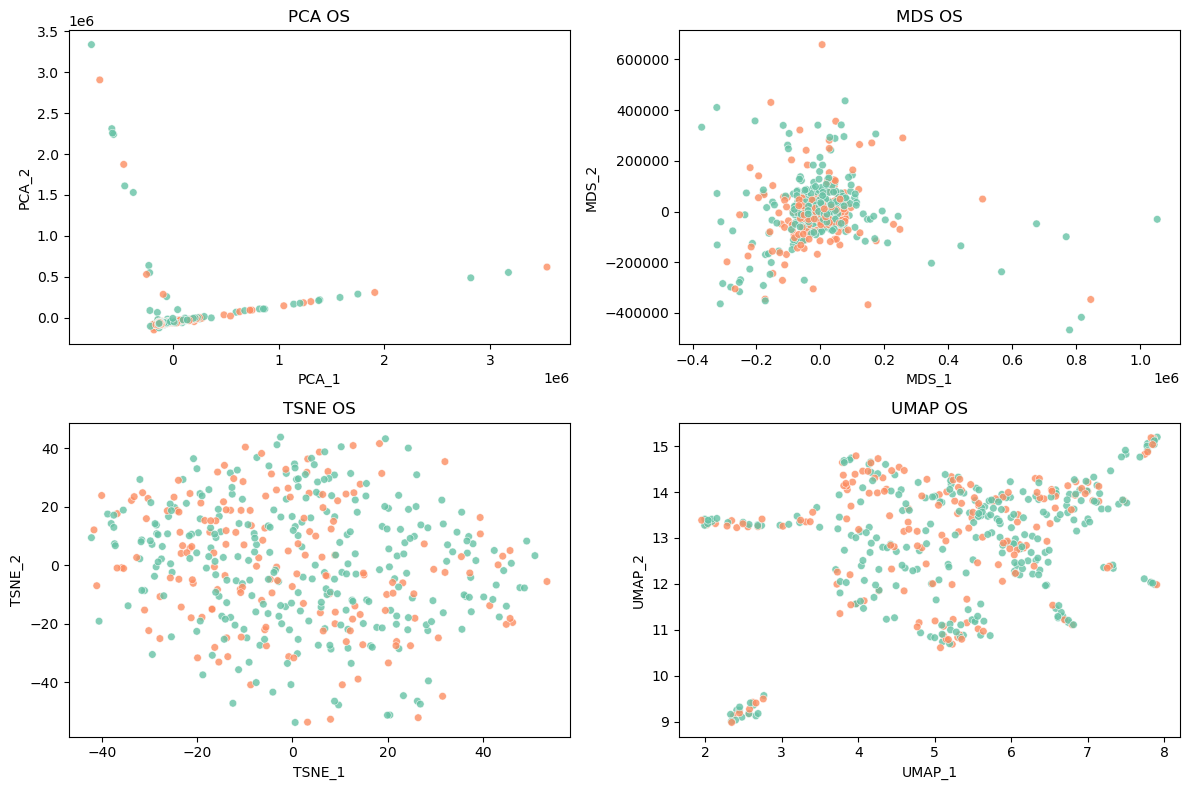

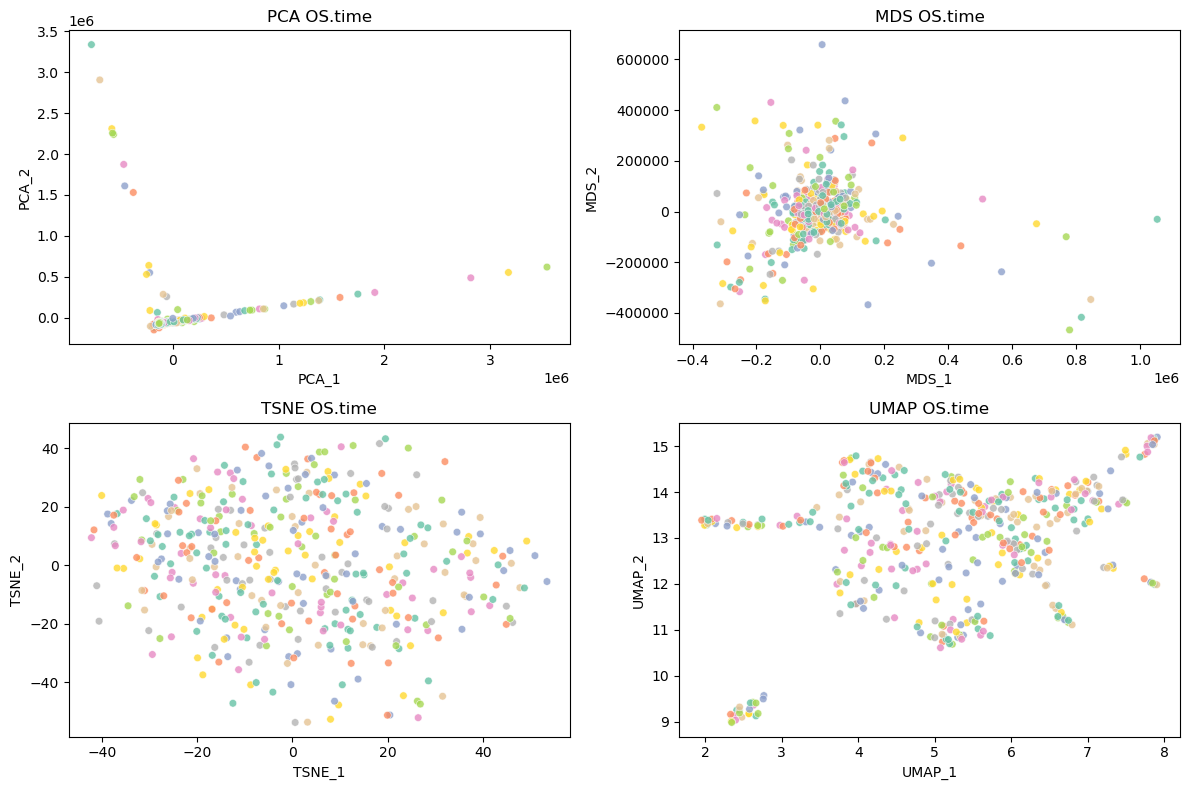

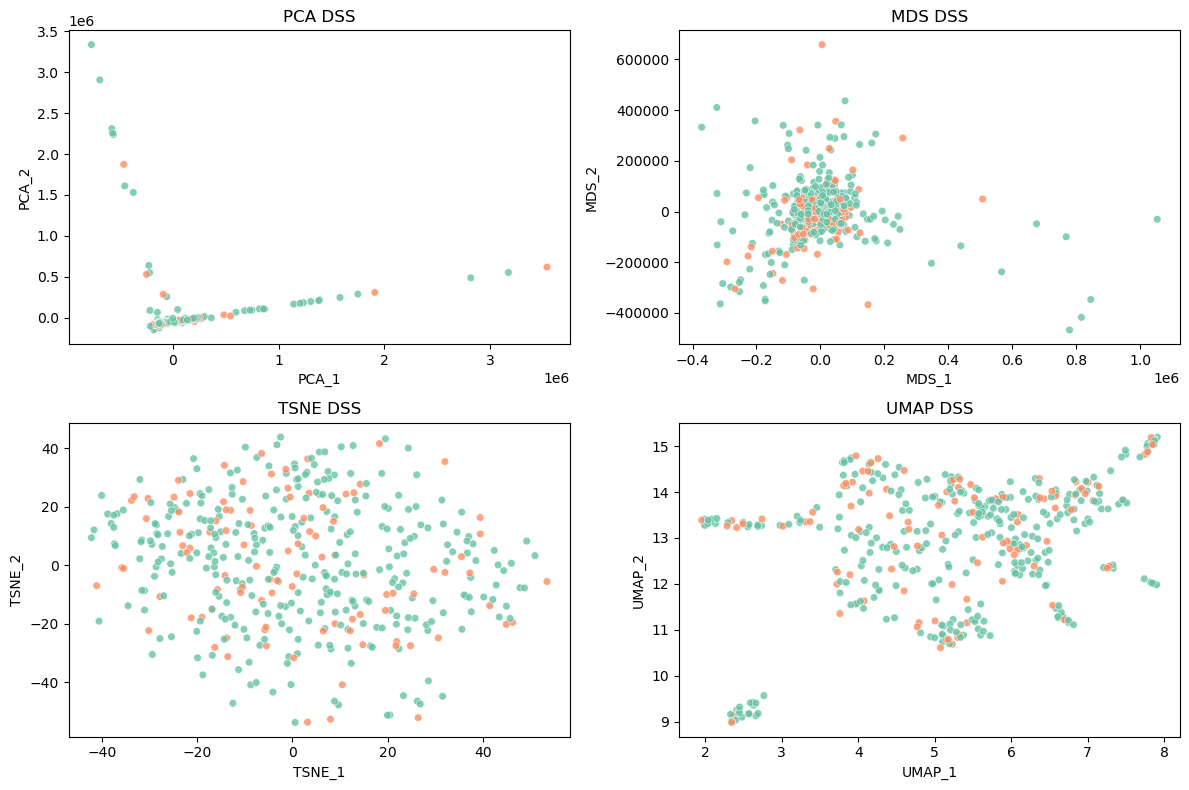

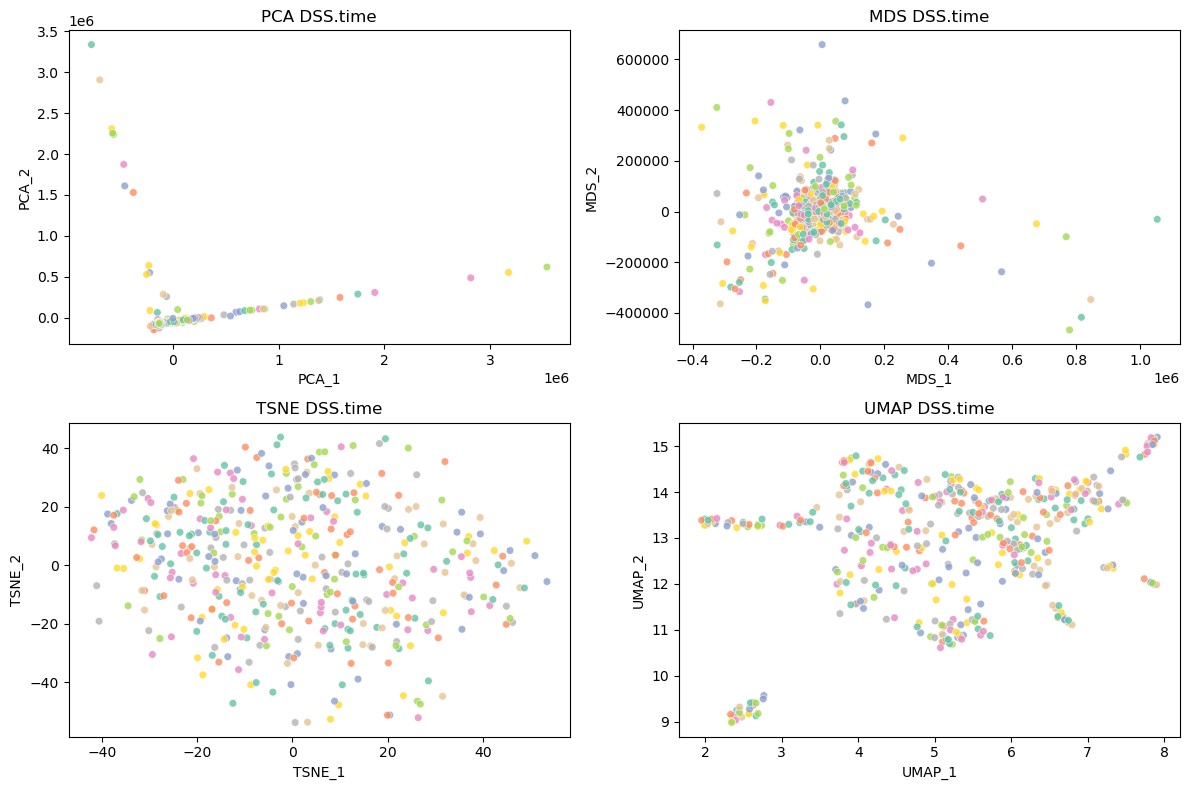

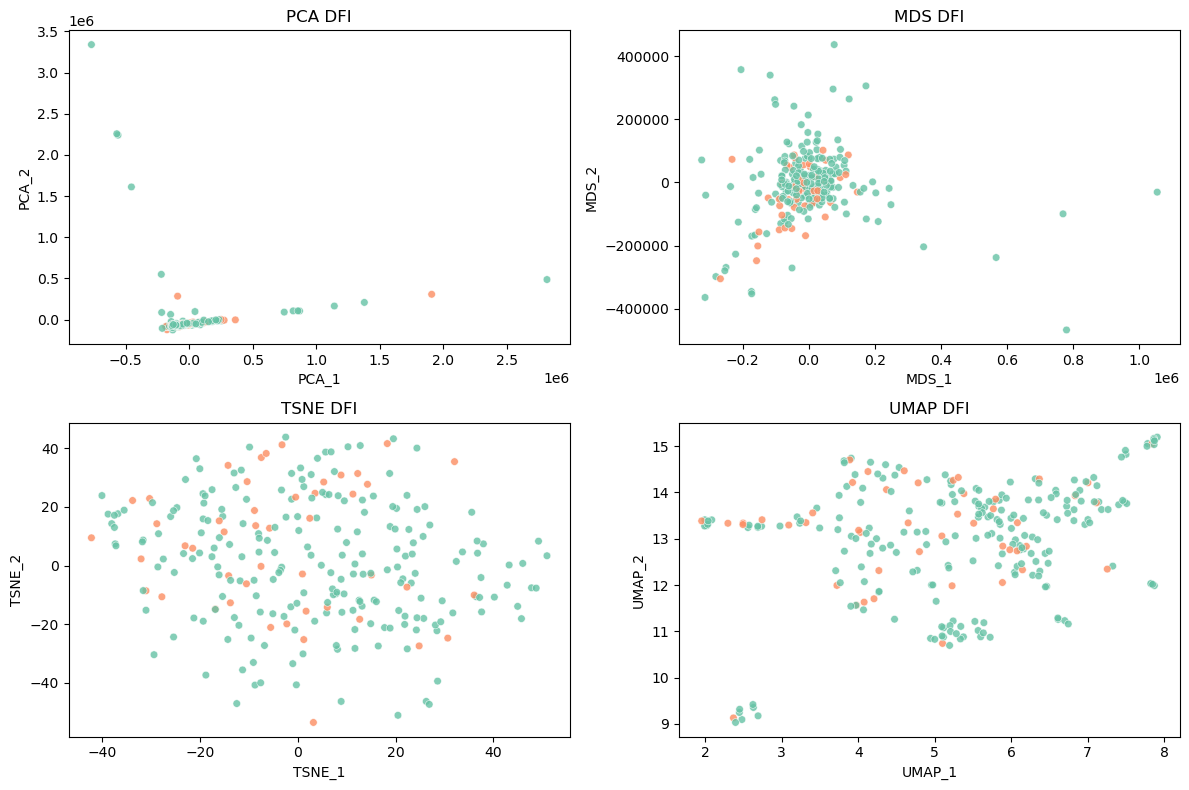

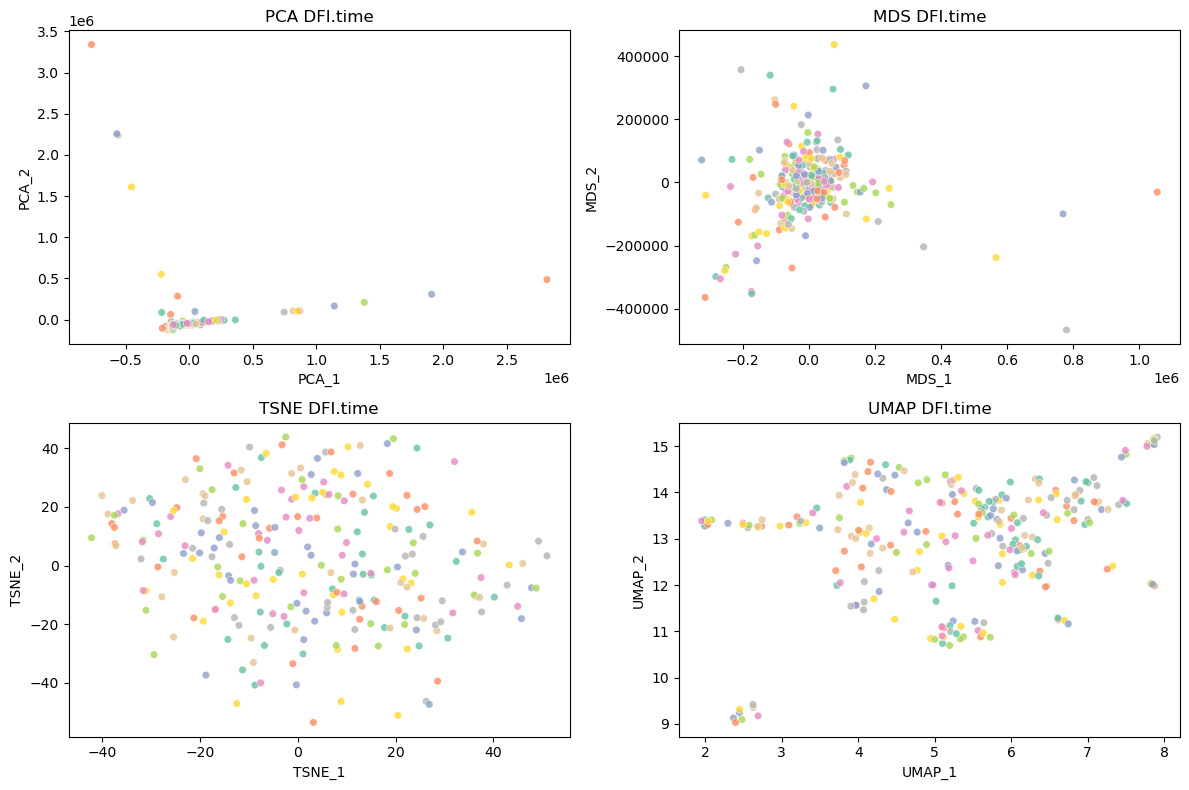

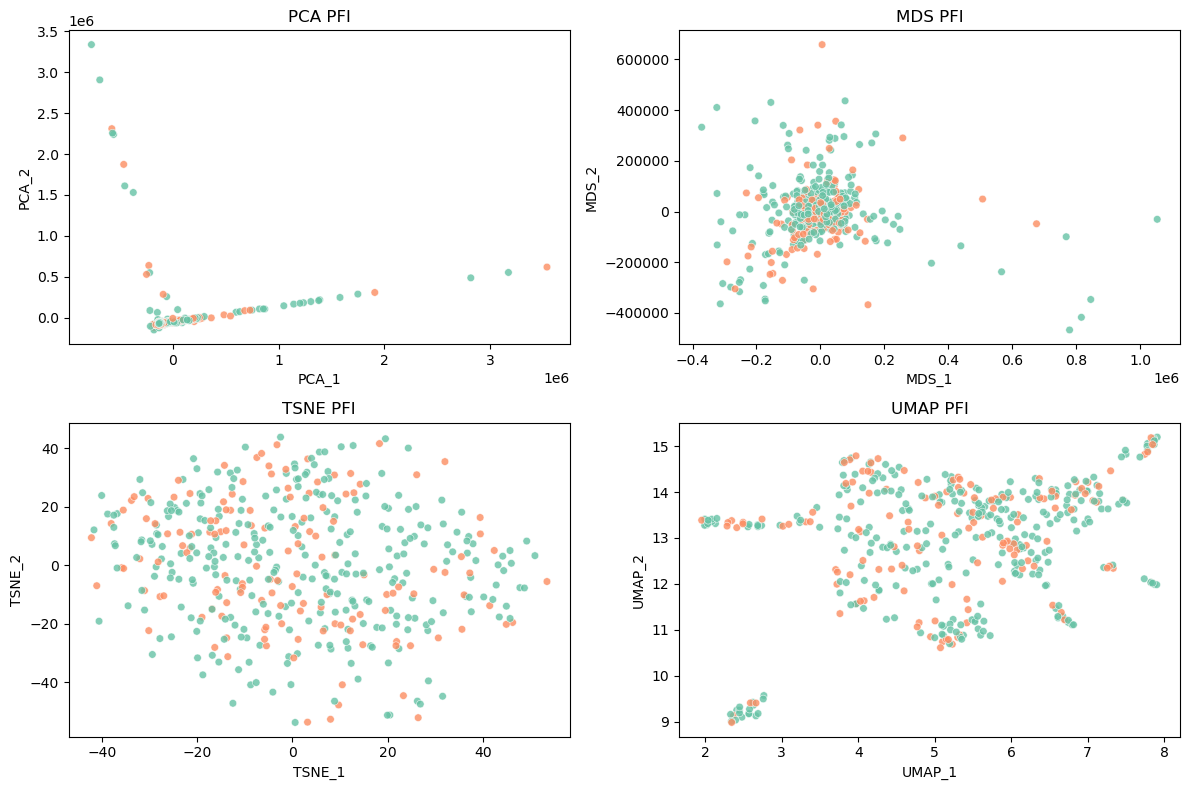

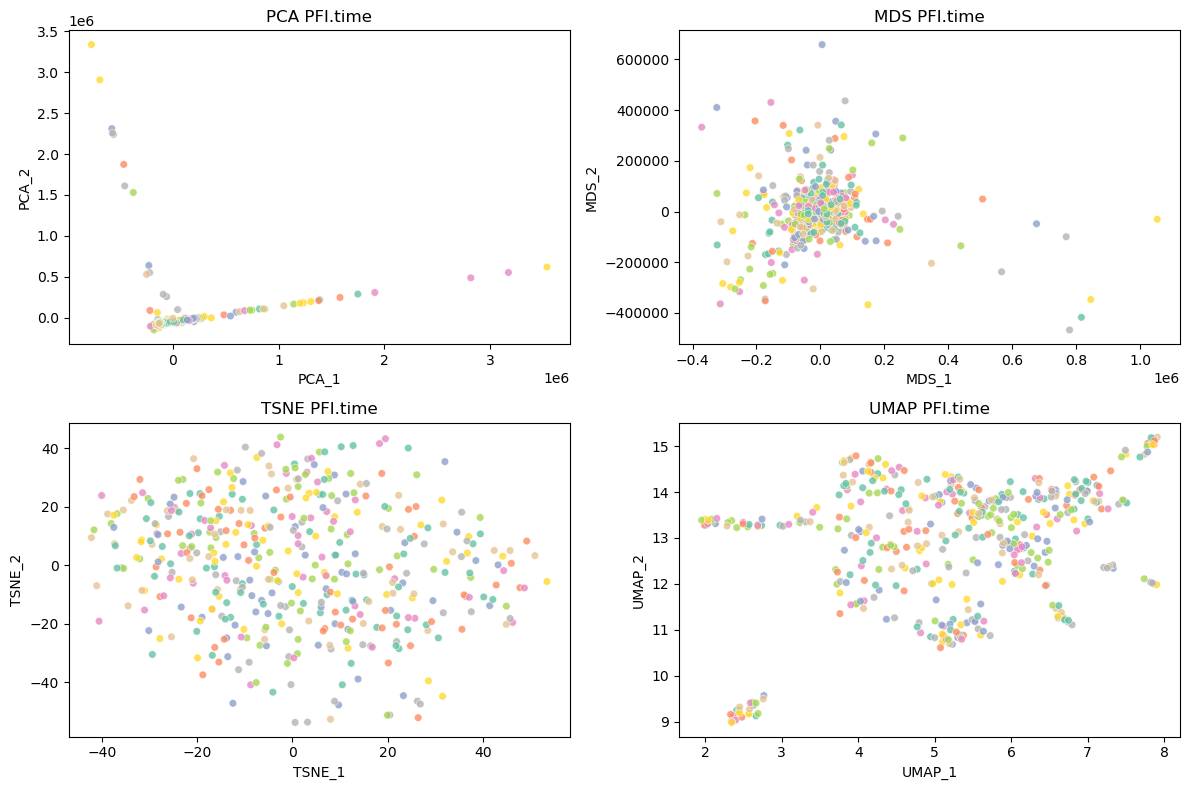

In [6]:
methods = ['PCA', 'MDS', 'TSNE', 'UMAP']

k = 4

for metric in metadata.columns[1:-1]:
    plt.figure(figsize=(12, 8))
    for i, method in enumerate(methods):
        plt.subplot(2, 2, i+1)
        x_col = method.upper() + '_1'
        y_col = method.upper() + '_2'
        cluster_col = f'{method.upper()}_{k}_cluster'

        sns.scatterplot(
            data=results, 
            x=x_col, 
            y=y_col, 
            hue=metric, 
            palette='Set2', 
            s=30, 
            alpha=0.8,
            legend=False
        )
        plt.title(f"{method.upper()} {metric}")
        plt.xlabel(x_col)
        plt.ylabel(y_col)

    plt.tight_layout()
    plt.show()

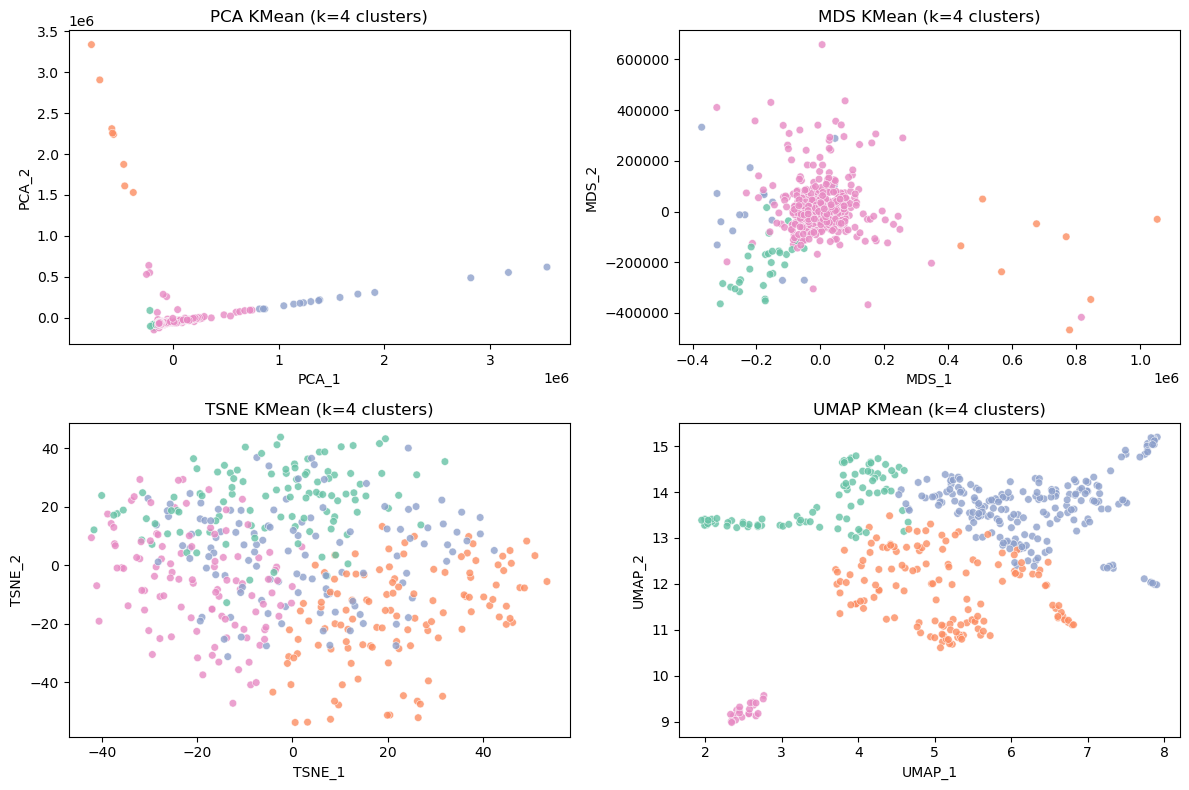

In [7]:
methods = ['PCA', 'MDS', 'TSNE', 'UMAP']

k = 4

# for metric in metadata.columns[1:-1]:

plt.figure(figsize=(12, 8))
for i, method in enumerate(methods):
    plt.subplot(2, 2, i+1)
    x_col = method.upper() + '_1'
    y_col = method.upper() + '_2'
    cluster_col = f'{method.upper()}_{k}_cluster'

    sns.scatterplot(
        data=results, 
        x=x_col, 
        y=y_col, 
        hue=cluster_col, 
        palette='Set2', 
        s=30, 
        alpha=0.8,
        legend=False
    )
    plt.title(f"{method.upper()} KMean (k={k} clusters)")
    plt.xlabel(x_col)
    plt.ylabel(y_col)

plt.tight_layout()
plt.show()

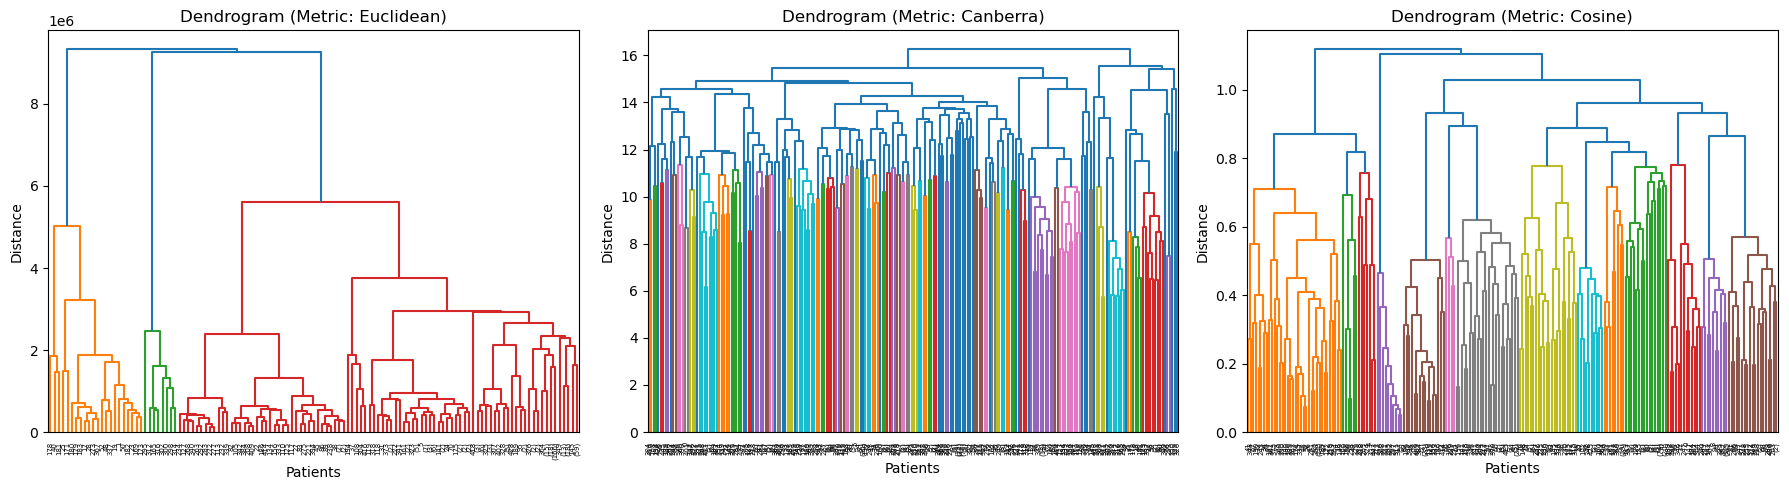

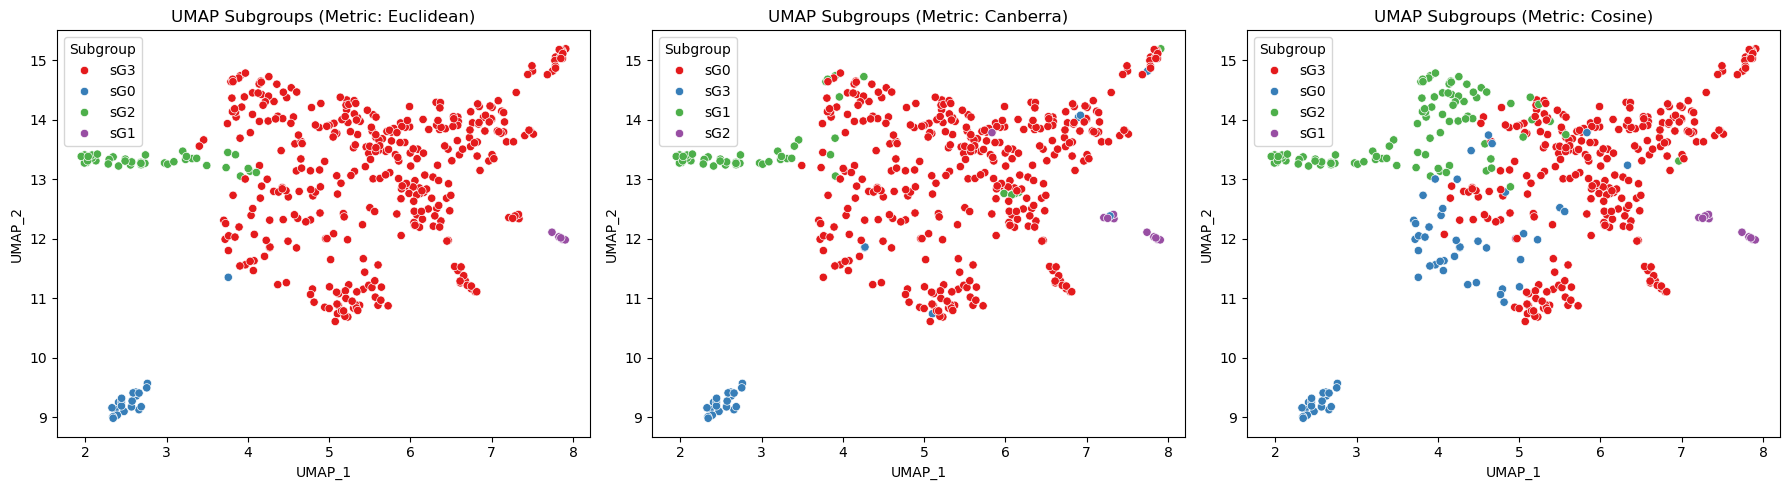

In [8]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

distance_metrics = ["euclidean", "canberra", "cosine"]
linkages = {}
subgroups = {}

for metric in distance_metrics:
    method = "ward" if metric == "euclidean" else "average"
    Z = linkage(mds_result, method=method, metric=metric)
    linkages[metric] = Z
    labels = fcluster(Z, t=4, criterion="maxclust")
    subgroups[metric] = labels

for metric in distance_metrics:
    results[f"Subgroup_{metric}"] = [f"sG{label-1}" for label in subgroups[metric]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    dendrogram(linkages[metric], ax=axes[i], truncate_mode="level", p=10) 
    axes[i].set_title(f"Dendrogram (Metric: {metric.capitalize()})")
    axes[i].set_xlabel("Patients")
    axes[i].set_ylabel("Distance")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(distance_metrics):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"Subgroup_{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1689459/269251247.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


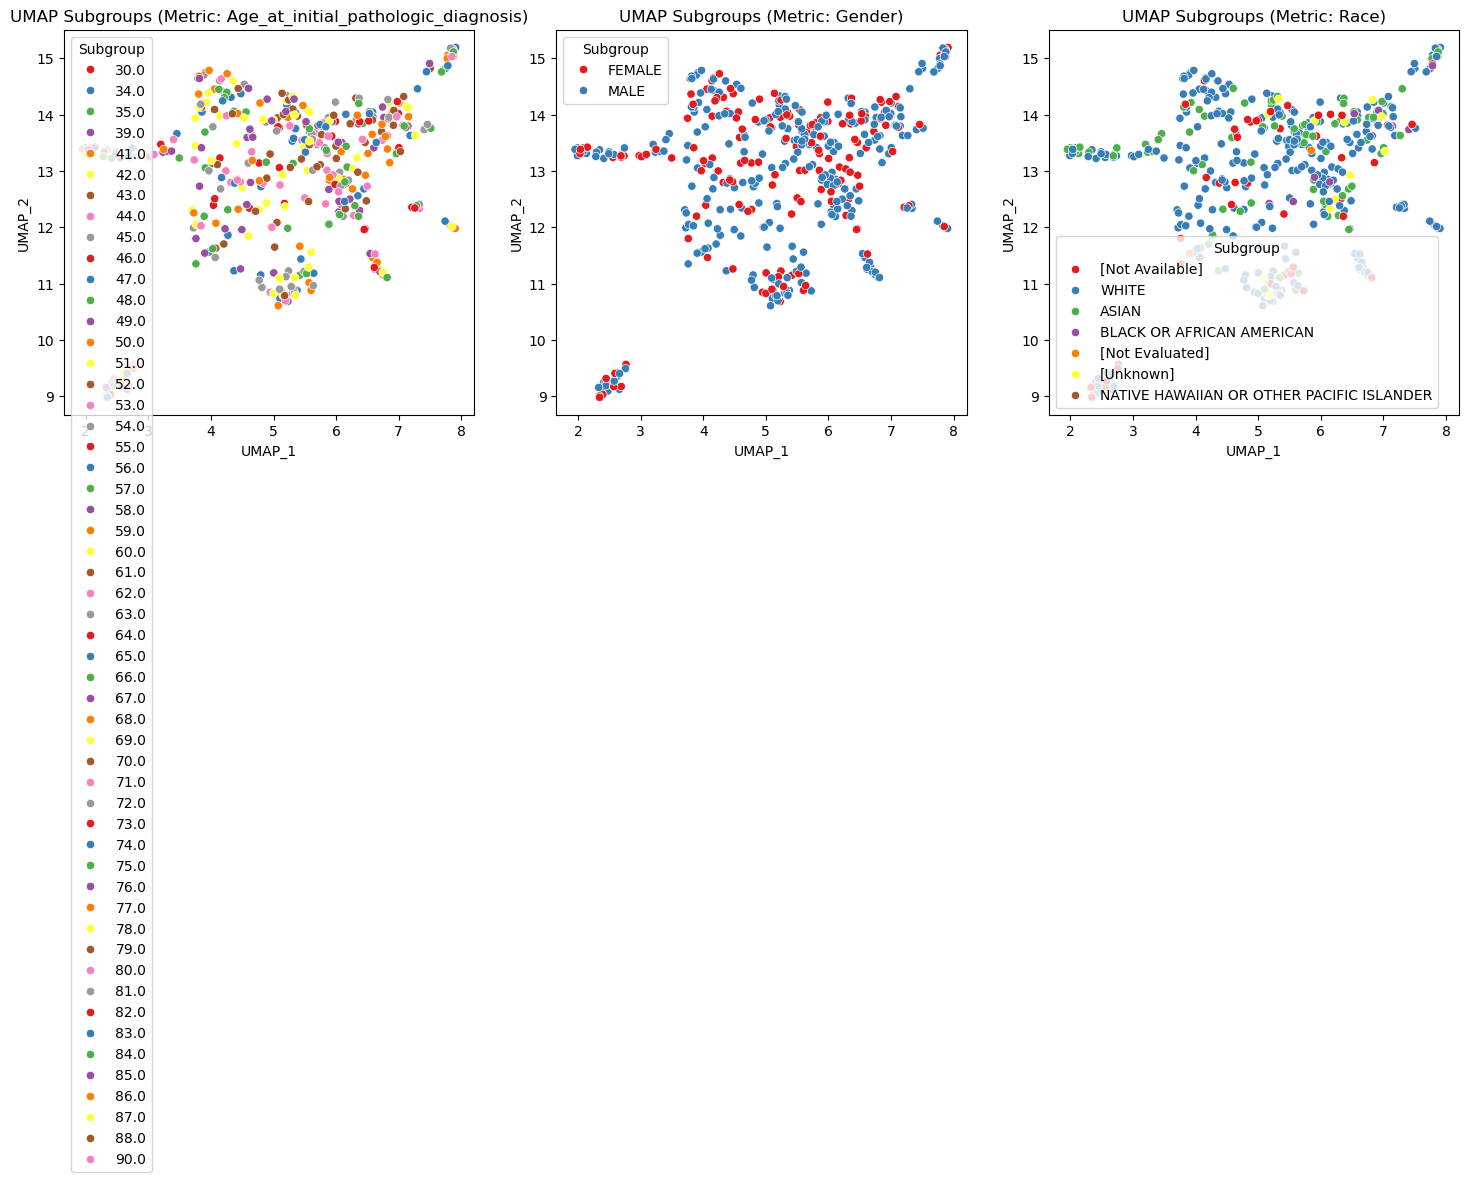

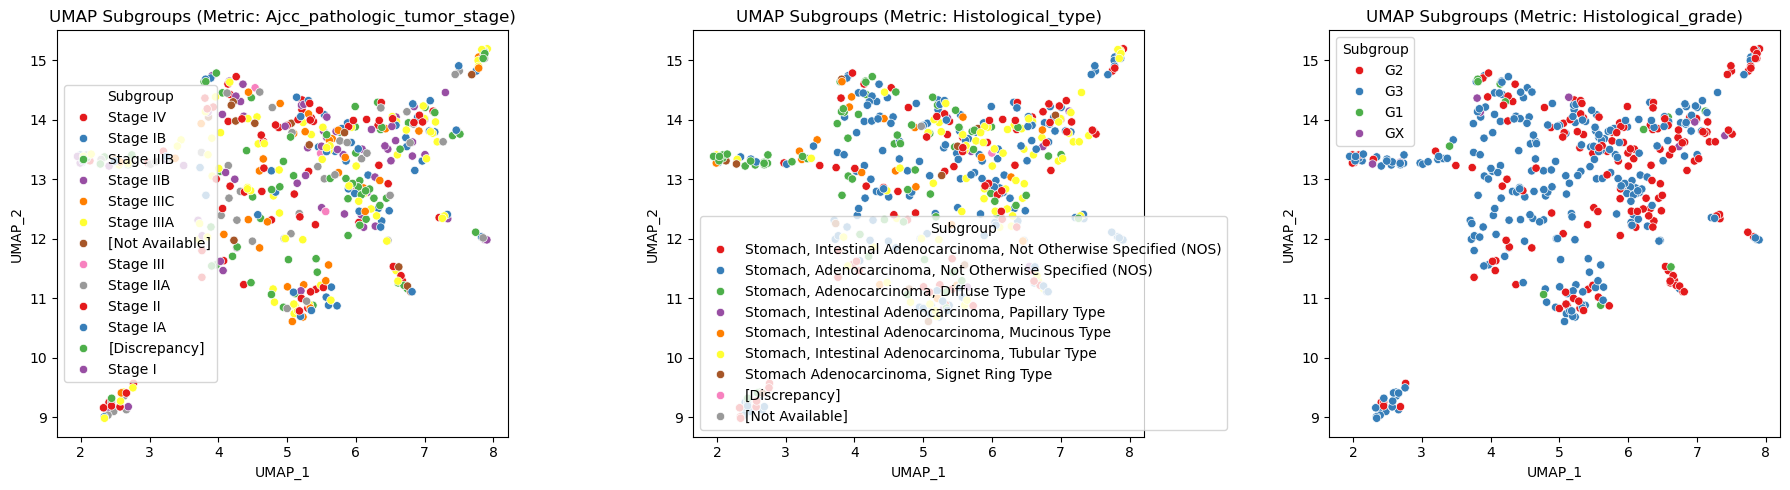

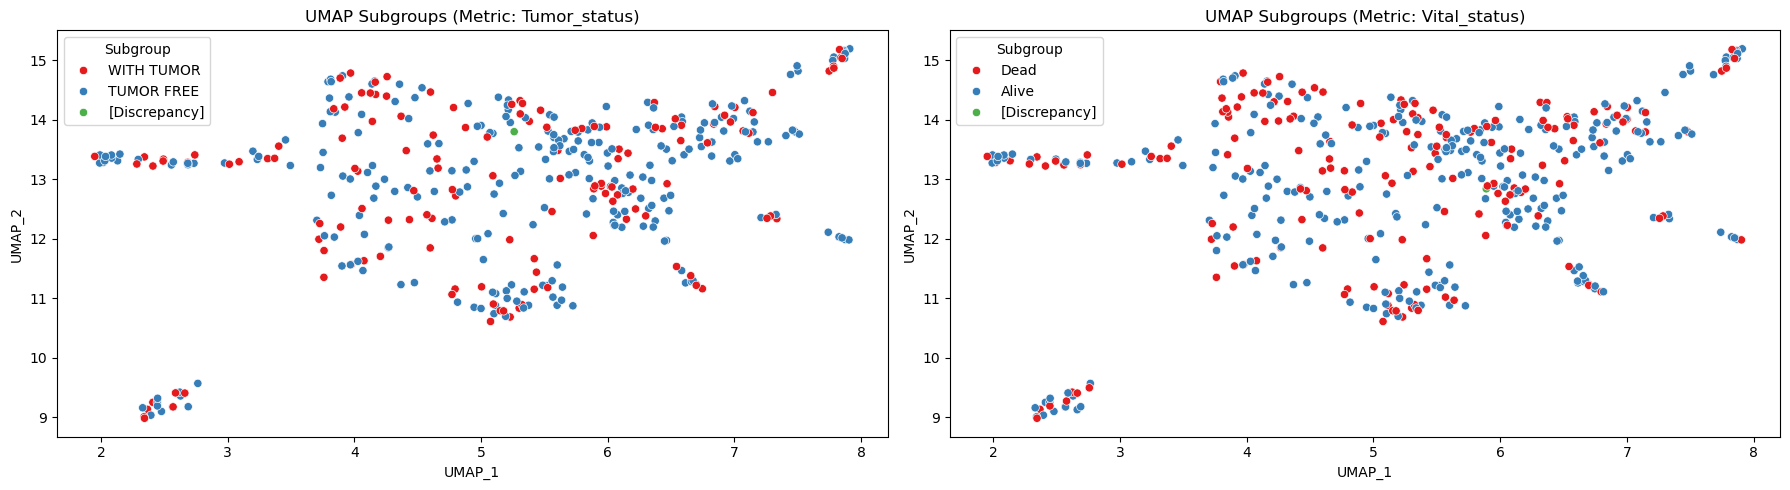

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['age_at_initial_pathologic_diagnosis', 'gender', 'race']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, metric in enumerate(['ajcc_pathologic_tumor_stage', 'histological_type','histological_grade']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for i, metric in enumerate(['tumor_status', 'vital_status']):
    sns.scatterplot(x="UMAP_1", y="UMAP_2", hue=f"{metric}", palette="Set1", data=results, ax=axes[i])
    axes[i].set_title(f"UMAP Subgroups (Metric: {metric.capitalize()})")
    axes[i].legend(title="Subgroup")
plt.tight_layout()
plt.show()